In [1]:
from FairFront import FairFront
from DataLoader_FairFront import load_data
from DiscreteFairFront import *
import numpy as np
import cvxpy as cp
import dccp

import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random
import pickle
import time
from tqdm import tqdm
from time import localtime, strftime

seed_n = 42
random.seed(seed_n)
np.random.seed(seed_n)

In [2]:
# read in data
import aif360 
from aif360.datasets import GermanDataset

label_map = {1.0: 'Good Credit', 2.0: 'Bad Credit'}
protected_attribute_maps = [{1.0: 'Male', 0.0: 'Female'}]
gd = GermanDataset(protected_attribute_names=['sex'], privileged_classes=[['male']], metadata={'label_map': label_map,'protected_attribute_maps': protected_attribute_maps})



`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df

In [3]:
# discretize 
def get_discrete_age(row):
    '''
    discretize the age column to <25 and >25, according to aif360 description
    '''
    row_age = row['age'] 
    if row_age < 25:
        return 0
    else:
        return 1

def get_discrete_amount(row):
    '''
    discretize the credit_amount column 
    '''
    row_amount = row['credit_amount'] 
    if row_amount < 5000:
        return 0
    elif row_amount < 10000:
        return 1
    else:
        return 2


def get_discrete_month(row):
    '''
    discretize the month column 
    '''
    row_month = row['month'] 
    if row_month < 36:
        return 0
    else:
        return 1
   
def convert_credit_column(row):
    '''
    make the two categories 0,1 instead of 1,2
    '''
    credit_label = row['credit']
    return (credit_label - 1)

In [4]:
# convert the German dataset into pandas df
df = gd.convert_to_dataframe()[0]
df.columns # a list of all features (some were converted during pre-processing to be one-hot)


Index(['month', 'credit_amount', 'investment_as_income_percentage',
       'residence_since', 'age', 'number_of_credits', 'people_liable_for',
       'sex', 'status=A11', 'status=A12', 'status=A13', 'status=A14',
       'credit_history=A30', 'credit_history=A31', 'credit_history=A32',
       'credit_history=A33', 'credit_history=A34', 'purpose=A40',
       'purpose=A41', 'purpose=A410', 'purpose=A42', 'purpose=A43',
       'purpose=A44', 'purpose=A45', 'purpose=A46', 'purpose=A48',
       'purpose=A49', 'savings=A61', 'savings=A62', 'savings=A63',
       'savings=A64', 'savings=A65', 'employment=A71', 'employment=A72',
       'employment=A73', 'employment=A74', 'employment=A75',
       'other_debtors=A101', 'other_debtors=A102', 'other_debtors=A103',
       'property=A121', 'property=A122', 'property=A123', 'property=A124',
       'installment_plans=A141', 'installment_plans=A142',
       'installment_plans=A143', 'housing=A151', 'housing=A152',
       'housing=A153', 'skill_level=A171

In [5]:
len(df.columns)

59

In [6]:

df['age'] = df.apply(lambda x: get_discrete_age(x), axis=1)
df['credit_amount'] = df.apply(lambda x: get_discrete_amount(x), axis=1)
df['month'] = df.apply(lambda x: get_discrete_month(x), axis=1)
df['credit'] = df.apply(lambda x: convert_credit_column(x), axis=1 )

In [7]:
# add a SY column for FairFront
def get_SY_column(row):
    if row['age'] == 0 and row['credit'] == 0:
        return 0
    elif row['age'] == 0 and row['credit'] == 1:
        return 1
    elif row['age'] == 1 and row['credit'] == 0:
        return 2
    else:
        return 3


df['SY'] = df.apply(lambda x: get_SY_column(x), axis=1)

### Approximate with discrete r.v.

In [8]:
df_save = df[['month', 'credit_amount', 
      'age', 'number_of_credits', 
       'sex',  'credit_history=A30', 'credit_history=A31', 'credit_history=A32',
       'credit_history=A33', 'credit_history=A34', 'savings=A61', 'savings=A62', 'savings=A63',
       'savings=A64', 'savings=A65', 'employment=A71', 'employment=A72',
       'employment=A73', 'employment=A74',  'employment=A75','credit','SY'
       ]]

In [9]:
# Open a file and use dump()
with open('german_data_processed.pkl', 'wb') as file: 
    # A new file will be created
    pickle.dump(df_save, file)

In [10]:
used_columns = df_save[['month', 'credit_amount', 
      'age', 'number_of_credits', 
       'sex',  'credit_history=A30', 'credit_history=A31', 'credit_history=A32',
       'credit_history=A33', 'credit_history=A34', 'savings=A61', 'savings=A62', 'savings=A63',
       'savings=A64', 'savings=A65', 'employment=A71', 'employment=A72',
       'employment=A73', 'employment=A74', 'employment=A75','SY']]


In [11]:
# select useful columns for computing FairFront
used_columns_names = ['month', 'credit_amount', 
      'age', 'number_of_credits', 
       'sex',  'credit_history=A30', 'credit_history=A31', 'credit_history=A32',
       'credit_history=A33', 'credit_history=A34', 'savings=A61', 'savings=A62', 'savings=A63',
       'savings=A64', 'savings=A65', 'employment=A71', 'employment=A72',
       'employment=A73', 'employment=A74',  'employment=A75',
       'SY']



In [12]:
df_save

,month,credit_amount,age,number_of_credits,sex,credit_history=A30,credit_history=A31,credit_history=A32,credit_history=A33,credit_history=A34,...,savings=A63,savings=A64,savings=A65,employment=A71,employment=A72,employment=A73,employment=A74,employment=A75,credit,SY
0,0,0,1,2.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2
1,1,1,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1
2,0,0,1,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2
3,1,1,1,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2
4,0,0,1,2.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2
996,0,0,1,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2
997,0,0,1,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2
998,1,0,0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1


In [13]:
pmf_dict = {0:{}, 1:{}, 2:{}, 3:{}}


def get_type_count(row):
    sy = row['SY']
    key = ()
    for column_name in used_columns_names[:-1]: # loop through column names except for 'SY'
        key = key + (row[column_name],) 
    if key not in pmf_dict[sy]:
        pmf_dict[sy].update({key: 1})
    else:
        pmf_dict[sy][key] =  pmf_dict[sy][key] + 1
          

for index, row in used_columns.iterrows():
    get_type_count(row)

for i in range(4):
    total_i = sum(pmf_dict[i].values())
    pmf_dict[i] = {key: value / total_i for key, value in pmf_dict[i].items()}


In [14]:
# output support as a list 
support_list = []
for i in range(4):
    support_list += list(pmf_dict[i].keys())

support_X = list(set(support_list)) # support of input features
calX = len(support_X)# support size of input features
calX


447

In [15]:
def get_pmf(dictionary, x):
    '''
    if x is in dictionary pmf_dict[i], then use that value. If not, fill in 0
    '''
    if x in dictionary:
        return dictionary[x]
    else:
        return 0 

# transition matrix from (s,y) to x
T_SY_X  = np.vstack([[get_pmf(pmf_dict[0], x) for x in support_X], \
           [get_pmf(pmf_dict[1], x) for x in support_X], \
           [get_pmf(pmf_dict[2], x) for x in support_X], \
           [get_pmf(pmf_dict[3], x) for x in support_X]
            ])

T_SY_X.shape

# can then use it to generate approximate for True FairFront

(4, 447)

#### Obtain transition matrix and conditional distribution

In [623]:
A = 2
C = 2
sensitive_s = 'age'
label_y = 'credit'
# get the mu_s,y values, encoded in matrix mu_SY
mu_SY = np.zeros((A, C))
mu_SY = np.zeros((2, 2))
for index, row in df.iterrows():
    s,y = int(row[sensitive_s]), int(row[label_y])
    mu_SY[s][y] = mu_SY[s][y] + 1
mu_SY = mu_SY/len(df)

map_ind_X = dict(zip(range(calX), support_X))
map_X_ind = dict(zip(support_X, range(calX)))

In [624]:
def g_emp(x):
    '''
    compute g function from the empirical distribution
    '''
    result_vector = []
    ind_x = map_X_ind[x]
    for s in range(A):
        for y in range(C):
            result_vector.append(T_SY_X[s*C + y, ind_x] * mu_SY[s][y])
    #normalize
    result_vector = result_vector/(sum(result_vector))
    return result_vector

distinf = {"T": T_SY_X, "map": map_ind_X, "mu_SY": mu_SY}

#### Generate FairFront

In [625]:
# fairness threshold
alpha_SP = 1.0
alpha_OAE = 1.0

# the sharp curve part

epsilon = []
opt_list = [] # List of FairFront values
opt_discrete_list = []

for i in np.linspace(0,0.06,10):
    print("current i:", i)
    epsilon.append(i)
    start_time = time.localtime()
    #FairFront_value = FairFront(A, C, g_emp,sensitive_s = sensitive_s, label_y=label_y,InputDist = True, dist_inf = distinf, alpha_SP = alpha_SP, alpha_EO = i , alpha_OAE = alpha_OAE, max_iterations = 20)

    #optimal_value,_,_ = FairFront_value.Algorithm()
    #opt_list.append(optimal_value)
    
    
    FairFront_discrete = DiscreteFairFront(A, C, mu_SY, distinf, alpha_SP = alpha_SP, alpha_EO = i, alpha_OAE = alpha_OAE)
    value = FairFront_discrete.FairFront()

    opt_discrete_list.append(value)
    
    
    print('Time for this iteration: {:4.3f} mins\n'.format((time.mktime(time.localtime()) - time.mktime(start_time))/60))
    print("opt_list:", opt_discrete_list)

current i: 0.0
Time for this iteration: 0.000 mins

opt_list: [0.8560060981517256]
current i: 0.006666666666666666
Time for this iteration: 0.000 mins

opt_list: [0.8560060981517256, 0.8569994304473638]
current i: 0.013333333333333332
Time for this iteration: 0.000 mins

opt_list: [0.8560060981517256, 0.8569994304473638, 0.8579927649863032]
current i: 0.019999999999999997
Time for this iteration: 0.017 mins

opt_list: [0.8560060981517256, 0.8569994304473638, 0.8579927649863032, 0.8589860975757991]
current i: 0.026666666666666665
Time for this iteration: 0.000 mins

opt_list: [0.8560060981517256, 0.8569994304473638, 0.8579927649863032, 0.8589860975757991, 0.8591191270197729]
current i: 0.03333333333333333
Time for this iteration: 0.000 mins

opt_list: [0.8560060981517256, 0.8569994304473638, 0.8579927649863032, 0.8589860975757991, 0.8591191270197729, 0.8591699615885005]
current i: 0.039999999999999994
Time for this iteration: 0.000 mins

opt_list: [0.8560060981517256, 0.8569994304473638

In [626]:
# the flat curve part
for i in np.linspace(0.07,0.2,8):
    print("current i:", i)
    epsilon.append(i)
    start_time = time.localtime()
    #FairFront_value = FairFront(A, C, g_emp,sensitive_s = sensitive_s, label_y=label_y,InputDist = True, dist_inf = distinf, alpha_SP = alpha_SP, alpha_EO = i , alpha_OAE = alpha_OAE, max_iterations = 20)

    #optimal_value,_,_ = FairFront_value.Algorithm()
    #opt_list.append(optimal_value)

    FairFront_discrete = DiscreteFairFront(A, C, mu_SY, distinf, alpha_SP = alpha_SP, alpha_EO = i, alpha_OAE = alpha_OAE)
    value = FairFront_discrete.FairFront()

    opt_discrete_list.append(value)
    
    
    print('Time for this iteration: {:4.3f} mins\n'.format((time.mktime(time.localtime()) - time.mktime(start_time))/60))
    print("opt_list:", opt_discrete_list)

        

current i: 0.07
Time for this iteration: 0.000 mins

opt_list: [0.8560060981517256, 0.8569994304473638, 0.8579927649863032, 0.8589860975757991, 0.8591191270197729, 0.8591699615885005, 0.8592207947561254, 0.8592716281602841, 0.859322461552078, 0.8593732918756416, 0.8594495405284188]
current i: 0.08857142857142858
Time for this iteration: 0.017 mins

opt_list: [0.8560060981517256, 0.8569994304473638, 0.8579927649863032, 0.8589860975757991, 0.8591191270197729, 0.8591699615885005, 0.8592207947561254, 0.8592716281602841, 0.859322461552078, 0.8593732918756416, 0.8594495405284188, 0.859591151627259]
current i: 0.10714285714285715
Time for this iteration: 0.000 mins

opt_list: [0.8560060981517256, 0.8569994304473638, 0.8579927649863032, 0.8589860975757991, 0.8591191270197729, 0.8591699615885005, 0.8592207947561254, 0.8592716281602841, 0.859322461552078, 0.8593732918756416, 0.8594495405284188, 0.859591151627259, 0.8597327591467903]
current i: 0.12571428571428572
Time for this iteration: 0.000 m

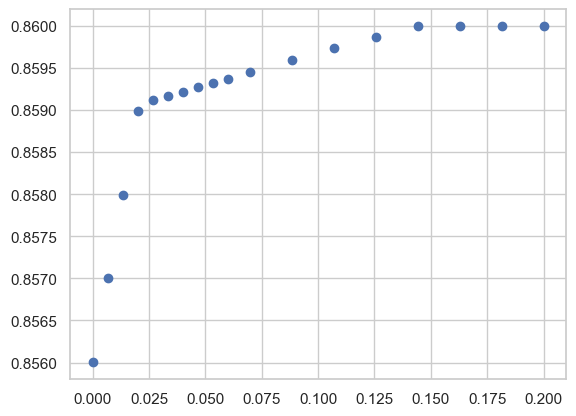

In [627]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pickle
sns.set(style="whitegrid")

plt.plot(epsilon, opt_discrete_list, 'o')